# Introduction

This notebook solves a version of Krusell and Smith's (1998) heterogenous-agent model with idiosyncrastic and aggregate shocks, incomplete markets and borrowing constraints. It uses a deep learning Euler-equation method introduced by Maliar, Maliar and Winant (2018) in the paper "Deep learning for solving dynamic economic models", Journal of Monetary Economics 122, pp 76-101. https://lmaliar.ws.gc.cuny.edu/files/2021/09/JME2021.pdf

This notebook shows a version of the Euler equation method that minimizes the sum of squared residuals in the equilibrium conditions. See https://deepecon.org for documentation, updates and the other versions of the deep learning method (Bellman equation and life-time reward). 

Copyright (c) 2019-2021 Marc Maliar. All rights reserved.

#### Importing required Python libraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # default run is on CPU
# comment the above two lines to enable GPU (can be much faster on some machines)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
import math
import time
import pickle

#### Disable eager execution (default in TensorFlow 2)

In [2]:
tf.compat.v1.disable_eager_execution() # turn on tensorflow 1 

# Deep learning method

In [3]:
AGENTS = 50     # number of agents
LEARNING_RATE = 1e-3
TRAINING_STEPS = 300000
BATCH_SIZE = 10
DISPLAY_STEP = 1000
TRAIN_STEP_INTERVAL = 2 # Interval of steps between training episodes
# In the first step, the model is simulated one step forward, and in the second step, it is trained

# Krusell and Smith's (1998) model

The economy consists of a set of heterogeneous agents $i=1,...,\ell $ that
are identical in fundamentals but differ in productivity and capital. Each
agent $i$ solves 
\begin{gather}
\underset{\left \{ c_{t}^{i},k_{t+1}^{i}\right \} _{t=0}^{\infty }}{\max }%
E_{0}\left[ \sum_{t=0}^{\infty }\beta ^{t}u\left( {c_{t}^{i}}\right) \right]
\label{iks} \\
\text{s.t. }w_{t+1}^{i}=R_{t+1}\left( w_{t}^{i}-c_{t}^{i}\right)
+W_{t+1}\exp \left( y_{t+1}^{i}\right) ,  \label{sks} \\
c_{t}^{i}\leq w_{t}^{i},  \label{rks}
\end{gather}
where $c_{t}^{i}$, $w_{t}^{i}$, $y_{t}^{i}$, $R_{t}$, $W_{t}$ and $%
k_{t+1}^{i}=w_{t}^{i}-c_{t}^{i}$ are consumption, cash-on-hand, labor
productivity, interest rate, wage and next-period capital, respectively.
Initial condition $\left( y_{0}^{i},w_{0}^{i}\right) $ is given. The
individual productivity evolves as 
\begin{equation}
y_{t+1}^{i}=\rho _{y}y_{t}^{i}+\sigma _{y}\epsilon _{t}^{i}\text{ with }
\epsilon _{t}^{i}\sim \mathcal{N}\left( 0,1\right) .  \label{ip}
\end{equation}
The production side of the economy is described by a Cobb-Douglas production
function $z_{t}Ak_{t}^{\alpha }\left[ \sum_{i=1}^{\ell }\exp \left(
y_{t}^{i}\right) \right]$, where A is technology level, $\alpha \in \left( 0,1\right) $ and $%
z_{t}$ is an aggregate productivity shock, 
\begin{equation}
z_{t+1}=\rho_{z} z_{t}+\sigma_{z} \epsilon _{t}\text{ with }\epsilon _{t}\sim 
\mathcal{N}\left( 0,1\right) .  \label{za}
\end{equation}
Initial condition $z_{0}$ is given. The equilibrium prices are
\begin{equation}
R_{t}=1-d+z_{t}\alpha Ak_{t}^{\alpha -1}\left[ \sum_{i=1}^{\ell }\exp \left(
y_{t}^{i}\right) \right] \text{ and }W_{t}=z_{t}\left( 1-\alpha \right)A
k_{t}^{\alpha }\left[ \sum_{i=1}^{\ell }\exp \left( y_{t}^{i}\right) \right]
,  \label{rw}
\end{equation}
where $k_{t}=\sum_{i=1}^{\ell }k_{t}^{i}$ is aggregate capital, and $d\in
\left( 0,1\right] $ is the depreciation rate. Note that $w_{t}^{i}=R_{t}k_{t}^{i}+W_{t}\exp \left( y_{t}^{i}\right) $. In the benchmark case, we
parametrize the model by $u\left( c\right) =\frac{c^{1-\gamma }-1}{1-\gamma }
$ with a risk-aversion coefficient of $\gamma =1$ and assume d=0.08, $\beta =0.96$, $%
\rho_{z} =0.95$, $\sigma_{z} =0.01$, $\rho _{y}=0.9$, and $\sigma _{y}=0.2\left(
1-\rho _{y}^{2}\right) ^{1/2}$.


# Preliminaries

#### Model parameters

In [4]:
α = 0.36    
d = 0.08    
A = 1       
β = 0.96 
γ = 1
d = 0.08

mean_z = 0.0    # aggregate productivity shock
ρ_z = 0.9
σ_z = 0.01

mean_y = 0.0 # idiosyncratic productivity shock
ρ_y = 0.95
σ_y = 0.2

#### Steady state

In [5]:
K_STEADY_STATE = (((1/β)-(1-d))/α/A)**(1/(α-1))           # capital
W_STEADY_STATE = K_STEADY_STATE*(1-d)+A*K_STEADY_STATE**α # wealth 
C_STEADY_STATE = A*K_STEADY_STATE**α-d*K_STEADY_STATE     # consumption
ξ_STEADY_STATE = C_STEADY_STATE/W_STEADY_STATE            # consumption-to-wealth ratio, ksi

## Stochastic solution domain

Our economy has 2*AGENTS + 1 state variables, which are wealth and productivity of all agents and an aggregate productivity. Our DL framework solves the model on stochastic simulation (ergodic set). When simulating the model, we: 
- restrict aggregate and individual productivities $z, y$ to be within ± 2*standard deviations $\frac{±\sigma}{\sqrt{1-\rho^2}}$;
- restrict $w$ to be within an interval: $w\in[w_{\min}, w_{\max}]$.

#### Bounds on state variables

In [6]:
# Bounds for aggregate productivity level
z_min = math.exp(-2 * σ_z  / math.sqrt(1-ρ_z**2))
z_max = math.exp(2 * σ_z  / math.sqrt(1-ρ_z**2))

# Bounds for individual productivity level
y_min = math.exp(-2 * σ_y  / math.sqrt(1-ρ_y**2))
y_max = math.exp( 2 * σ_y  / math.sqrt(1-ρ_y**2))

# Cash-on-hand's bounds
w_min = 0.0*W_STEADY_STATE
w_max = 4.0*W_STEADY_STATE

#### Model functions

In [7]:
def mean_across_agents(x):
    return tf.reduce_mean(x, axis=1, keepdims=True)

def consumption_capital(w, ξ):
    c = w*ξ
    kp = w*(1-ξ)                    # k' = next-period indovodual capital
    kp = tf.math.minimum(kp, w_max) # if kp>W_HIGH, set kp=W_HIGH
    c = w - kp                      # recompute c 
   
    return c, kp

def next_period(kp, yp, zp):
    kp_aggregate = mean_across_agents(kp)
    rp = A*zp*α*kp_aggregate**(α-1)      # next-period interest rate
    wagep = A*zp*(1-α)*kp_aggregate**(α) # next-period wage
    wp = (1-d+rp)*kp+wagep*yp            # individual next-period wealth
    
    return rp, wp

def productivity_transition_to_next_period(y, z, εy, εz):
    yp = y**ρ_y*tf.math.exp(εy)*math.exp((-0.5*(1-ρ_y)*σ_y**2)/(1-ρ_y**2))
        # exp((-0.5*(1-ρ_y)*σ_y**2)/(1-ρ_y**2)) makes mean = 1
    yp = tf.math.minimum(tf.math.maximum(yp, y_min), y_max)
        # restrict the individual productivity to be within the bounds
    yp = yp / mean_across_agents(yp)
        # normalize future individual shocks so that they sum up to one 
    
    zp = z**ρ_z*tf.math.exp(εz)*math.exp((-0.5*(1-ρ_z)*σ_z**2)/(1-ρ_z**2))
    zp = tf.math.minimum(tf.math.maximum(zp, z_min), z_max)
        # the same for aggregare productivity except of normalizing to one
    return yp, zp 

def normalize_all(w, y, z):                                # normalize inputs for neural network
    normw = (w - w_min) / (w_max-w_min)*2.0 - 1.0          # normalize to interval [-1,1]
    normy = tf.math.log(y) / (2*σ_y / math.sqrt(1-ρ_y**2)) # normalize to ±2standard deviations to approximately fit to [-1,1]
    normz = tf.math.log(z) / (2*σ_z / math.sqrt(1-ρ_z**2)) 
    
    return normw, normy, normz

# The neural-network

#### Parameterization of decision functions with neural networks

We parametrize the consumption to
wealth ratio $\frac{c_{t}^{i}}{w_{t}^{i}}$ and unit-free Lagrange multiplier $%
h_{t}^{i}$:
\begin{eqnarray*}
\xi_t=\frac{c_{t}^{i}}{w_{t}^{i}} &=&\sigma \left( \zeta _{0}+\eta \left(
y_{t}^{i},w_{t}^{i},D_{t},z_{t};\vartheta \right) \right) \equiv \varphi
\left( \cdot ;\theta \right), \\
h_{t}^{i} &=&\exp \left( \zeta _{0}+\eta \left(
y_{t}^{i},w_{t}^{i},D_{t},z_{t};\vartheta \right) \right) \equiv h\left(
\cdot ;\theta \right), 
\end{eqnarray*}
where $\eta \left( \cdot ;\vartheta \right) $ is a neural network, $%
D_{t}\equiv \left \{ y_{t}^{i},w_{t}^{i}\right \} _{i=1}^{\ell }$ is the
distribution, $\theta \equiv \left( \zeta _{0},\vartheta \right) $ and $%
\sigma \left( x\right) =\frac{1}{1+e^{-x}}$.

A sigmoid transformation of $\varphi \left( \cdot ;\theta \right) $ ensures
that $\frac{c_{t}^{i}}{w_{t}^{i}}$ is in the interval $\left[ 0,1\right] $;
the exponentiation of $h_{t}$ ensures that it is nonnegative. The parameter $%
\zeta _{0}$ is calibrated, and the biases and weights are initialized
randomly by using "he" and "glorot" uniform distributions,
respectively. In the baseline case, we use a neural network with a sigmoid
activation function and two hidden layers of $32\times 32$ neurons.

#### Architecture

In [8]:
input_dimension = 2*AGENTS+3           # inputs consist of 
                                       # 2 state variables of a given agent i (wealth and productivities)
                                       # 2*AGENTS state variables of all agents 
                                       # 1 aggregate productivity 
first_hidden_layer_neurons = 32
second_hidden_layer_neurons = 32
output_dimension = 2                   # ksi (share of consumption in wealth), multiplier (on the borrowing constraint)

#### Resulting layer shapes (weights and biases)

In [9]:
first_hidden_layer_weights_shape = \
    (input_dimension,             first_hidden_layer_neurons)
# E.g., with 10 agents and 4 neurons, it's 23-by-4, where input_dimension = 23 with 10 agents
first_hidden_layer_biases_shape  = \
    (1,                           first_hidden_layer_neurons)

second_hidden_layer_weights_shape = \
    (first_hidden_layer_neurons,  second_hidden_layer_neurons)
# E.g., 4 neurons in each hidden leayer, it's 4-by-4
second_hidden_layer_biases_shape  = \
    (1,                           second_hidden_layer_neurons)

output_layer_weights_shape = \
    (second_hidden_layer_neurons, output_dimension)
output_layer_biases_shape  = \
    (1,                           output_dimension)

#### Creating the neural-network weights in TensorFlow

In [10]:
# Weights initializers
he_normal_initializer = tf.keras.initializers.he_normal()
zero_initializer = tf.keras.initializers.Constant(value=0.0)
small_initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01, seed=None)

first_hidden_layer_weights = \
    tf.compat.v1.get_variable(name = "first_hidden_layer_weights", 
                              shape=first_hidden_layer_weights_shape, 
                              initializer=small_initializer)

first_hidden_layer_biases = \
    tf.compat.v1.get_variable(name = "first_hidden_layer_biases", 
                              shape=first_hidden_layer_biases_shape, 
                              initializer=zero_initializer)


second_hidden_layer_weights = \
    tf.compat.v1.get_variable(name = "second_hidden_layer_weights", 
                              shape=second_hidden_layer_weights_shape, 
                              initializer=small_initializer)

second_hidden_layer_biases = \
    tf.compat.v1.get_variable(name = "second_hidden_layer_biases", 
                              shape=second_hidden_layer_biases_shape, 
                              initializer=zero_initializer)

output_layer_weights = \
    tf.compat.v1.get_variable(name = "output_layer_weights", 
                              shape=output_layer_weights_shape, 
                              initializer=small_initializer)

output_layer_biases = \
    tf.compat.v1.get_variable(name = "output_layer_biases", 
                              shape=output_layer_biases_shape, 
                              initializer=zero_initializer)

#### The neural-network function

In [11]:
def neural_network(input_tensor):

    first_hidden_layer_result = \
        tf.add(tf.matmul(input_tensor, first_hidden_layer_weights), first_hidden_layer_biases)
    # The number of weights connecting inputs and the 1st hiddent layer is (2*AGENTS+3)-by-(first_hidden_layers_neurons); 
    # to the resulting number, we add biases
    
    first_hidden_layer_result_sigmoided = tf.nn.sigmoid(first_hidden_layer_result)
    # Apply a sigmoid activation function

    second_hidden_layer_result = \
        tf.add(tf.matmul(first_hidden_layer_result_sigmoided, second_hidden_layer_weights), second_hidden_layer_biases)
    
    second_hidden_layer_result_sigmoided = tf.nn.sigmoid(second_hidden_layer_result)
    # Apply a sigmoid activation-function
    
    output_layer_result = \
        tf.add(tf.matmul(second_hidden_layer_result_sigmoided, output_layer_weights), output_layer_biases)
    
    # Don´t apply sigmoid to the last layer, we will do it later when necessary
    
    return output_layer_result

#### NN functions that produce decision variables

In [12]:
def run_neural_network_for_all_agents_given_state(w, y, z):
    
    # Normalize the states used in the neural network
    normw, normy, normz = normalize_all(w, y, z)

    normw_unstacked = tf.unstack(normw, axis=1) # transform a 2D tensors into a list of 1D tensors
    normy_unstacked = tf.unstack(normy, axis=1) # transform a 2D tensors into a list of 1D tensors
        # 2D tensors are of size BATCH_SIZE-by-AGENTS
    
    dim_list = lambda l: list(map(lambda x: tf.expand_dims(x, axis=0), l))
       
    sum_information = dim_list(normw_unstacked+normy_unstacked)
    concat = [tf.concat(
        sum_information+
        [tf.transpose(normz, [1, 0]), 
        tf.expand_dims(normw_unstacked[i], 0), 
        tf.expand_dims(normy_unstacked[i], 0)], axis=0)
              for i in range(AGENTS)]
    
    stack = tf.stack(concat, axis=1)
    input_tensor = tf.reshape(tf.transpose(stack, perm=[2, 1, 0]), [-1, input_dimension]) 
        # Batches, agents, input
    output_tensor = neural_network(input_tensor) 
        # Batches, agents*output
    
    output_tensor_reshaped = tf.reshape(output_tensor, [-1, AGENTS, output_dimension])
    
    ξ_before_sigmoid, μ_before_exp = tf.unstack(output_tensor_reshaped, axis=2)
    def logit(x):
        return np.log(x/(1-x)) # Inverse of sigmoid
    ξ = tf.sigmoid(ξ_before_sigmoid+logit(ξ_STEADY_STATE))
    μ = tf.exp(μ_before_exp)
    
    return ξ, μ
        # given state variables, we get ksi (share of consumption in wealth), multiplier (on the borrowing constraint)

# Define the model through a TensorFlow computational graph

#### Euler objective function for training

Our Euler objective function for Krusell and Smith's (1998) model is
based on all-in-one expectation operator of two uncorrelated shocks (see the paper for a discussion of this technique): 
\begin{multline}
\Xi (\theta )=E_{\omega }\left[ \xi \left( \omega ;\theta \right) \right]
=E_{\left( Y_{t},W_{t},z_{t},\Sigma _{1},\Sigma _{2},\epsilon _{1,},\epsilon
_{2}\right) }\left \{ \left[ \Psi ^{FB}\left( 1-\frac{c_{t}^{i}}{w_{t}^{i}}%
,1-h_{t}^{i}\right) \right] ^{2}\right.  \label{MC_2ks} \\
\left. +v\left[ \frac{\beta R_{t+1}\left. u^{\prime }\left(
c_{t+1}^{i}\right) \right \vert _{\Sigma =\Sigma _{1},\epsilon =\epsilon
_{1}}}{u^{\prime }\left( c_{t}^{i}\right) }-h_{t}^{i}\right] \left[ \frac{%
\beta R_{t+1}\left. u^{\prime }\left( c_{t+1}^{i}\right) \right \vert
_{\Sigma =\Sigma _{2},\epsilon =\epsilon _{2}}}{u^{\prime }\left(
c_{t}^{i}\right) }-h_{t}^{i}\right] \right \},
\end{multline}
where $
Y_{t}=\left( y_{t}^{1},...,y_{t}^{\ell }\right) $ and $W_{t}=\left(
w_{t}^{1},...,w_{t}^{\ell }\right) $ and $z_{t}$ are the economy's state
produced stochastic simulation; $\Sigma _{1}=\left( \epsilon
_{1}^{1},...,\epsilon _{1}^{\ell }\right) $, $\Sigma _{2}=\left( \epsilon
_{2}^{1},...,\epsilon _{2}^{\ell }\right) $ are two uncorrelated random
draws of individual productivity shocks; and $\epsilon _{1,}$, $\epsilon
_{2} $ are two uncorrelated random draws for the aggregate productivity
innovations.


#### TensorFlow placeholder tensors which we will feed data into

In [13]:
# Inputs
w0 = tf.compat.v1.placeholder("float32", [None, AGENTS]) # current wells
y0 = tf.compat.v1.placeholder("float32", [None, AGENTS]) # current individual productivity
z0 = tf.compat.v1.placeholder("float32", [None, 1])      # current aggregate productivity

# First shock
εy_a = tf.compat.v1.placeholder("float32", [None, AGENTS]) # individual innovation
εz_a = tf.compat.v1.placeholder("float32", [None, 1])      # aggregate innovation

# Second shock
εy_b = tf.compat.v1.placeholder("float32", [None, AGENTS])
εz_b = tf.compat.v1.placeholder("float32", [None, 1])

#### Apply model functions to placeholder tensors to generate computational graph

In [14]:
# Current time period
ξ0, μ0 = run_neural_network_for_all_agents_given_state(w0, y0, z0)
c0, k1 = consumption_capital(w0, ξ0)

y1_a, z1_a = productivity_transition_to_next_period(y0, z0, εy_a, εz_a)
r1_a, w1_a = next_period(k1, y1_a, z1_a)
ξ1_a, μ1_a = run_neural_network_for_all_agents_given_state(w1_a, y1_a, z1_a)
c1_a, k2_a = consumption_capital(w1_a, ξ1_a)

y1_b, z1_b = productivity_transition_to_next_period(y0, z0, εy_b, εz_b)
r1_b, w1_b = next_period(k1, y1_b, z1_b)
ξ1_b, μ1_b = run_neural_network_for_all_agents_given_state(w1_b, y1_b, z1_b)
c1_b, k2_b = consumption_capital(w1_b, ξ1_b)

#### Define error tensors and train operations for training

In [15]:
# Error 1
R_μ = μ0 - 1
R_ξ = w0 / c0 - 1
R_μξ = R_μ+R_ξ-tf.math.sqrt(R_μ**2+R_ξ**2) # residual in the Fisher-Burmeister function; eq. (25) in MMV (2021)

# Error 2
R2_a = β*(c1_a**(-γ))*(1-d+r1_a)/(c0**(-γ))-μ0 # residual in the Euler equation under shock a 
R2_b = β*(c1_b**(-γ))*(1-d+r1_b)/(c0**(-γ))-μ0 

Residual1 = tf.reduce_mean(R_μξ**2)
Residual2 = tf.reduce_mean(R2_a*R2_b)

# Mean squared errors
loss_op = Residual1 + Residual2

# Training

#### Make empty loss-value vector

In [16]:
loss_vals = np.empty((TRAINING_STEPS, 1)) # Return a new array of size TRAINING_STEPS-by-1

#### Optimizer

In [17]:
# Define the optimization method to be used
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=LEARNING_RATE)
train_op = optimizer.minimize(loss_op) 

#### Define group of tensors of train that we will compute

In [18]:
# Tensors that will be ran when we don't want to train the model
# (need for the step when the model is simulated forward without training)
tensors_to_run_no_train = {
    "w1": w1_a,
    "y1": y1_a,
    "z1": z1_a,
    "loss": loss_op,
    "debug": [Residual1, Residual2]
}

# Tensors that will be ran when we do want to train
# (need for the step when the model is trained)
tensors_to_run_train = {
    "w1": w1_a,
    "y1": y1_a,
    "z1": z1_a,
    "loss": loss_op,
    
    "train": [train_op],

    "debug": [Residual1, Residual2]
}
# 

#### Functions used to generate shocks

In [19]:
def initial_state(required_batch_size):
    w = np.reshape(np.random.uniform(W_STEADY_STATE, W_STEADY_STATE, required_batch_size*AGENTS), \
                   (required_batch_size, AGENTS))
    y = np.reshape(np.random.uniform(1, 1, required_batch_size*AGENTS), (required_batch_size, AGENTS))
    z = np.reshape(np.random.uniform(1, 1, required_batch_size), (required_batch_size, 1))
    return w, y, z
        # initial condition is taken in steady state
    
def generate_εy(required_batch_size):
    return np.reshape(np.random.normal(mean_y, σ_y, required_batch_size*AGENTS), (required_batch_size, AGENTS))
        # generate shocks to y
    
def generate_εz(required_batch_size):
    return np.reshape(np.random.normal(mean_z, σ_z, required_batch_size), (required_batch_size, 1))
        # generate shocks to z

#### Start the TensorFlow session and initialize weights

In [20]:
# Start TensorFlow session
sess=tf.compat.v1.Session()
    
# Initialize global variables
sess.run(tf.compat.v1.global_variables_initializer())

2021-12-14 23:18:32.249316: E tensorflow/stream_executor/rocm/rocm_driver.cc:983] could not retrieve ROCM device count: HIP_ERROR_NoDevice
2021-12-14 23:18:32.249731: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-14 23:18:32.250390: E tensorflow/stream_executor/rocm/rocm_driver.cc:983] could not retrieve ROCM device count: HIP_ERROR_NoDevice
2021-12-14 23:18:32.577138: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


#### Training

In [21]:
# Start timer
start = time.time()

w_train, y_train, z_train = initial_state(required_batch_size = BATCH_SIZE)
    # construct initial condition in the steady state

for i in range(TRAINING_STEPS):
    # Get 2 uncorrelated shocks for y and z
    εy_a_train = generate_εy(BATCH_SIZE)
    εy_b_train = generate_εy(BATCH_SIZE)
    
    εz_a_train = generate_εz(BATCH_SIZE)
    εz_b_train = generate_εz(BATCH_SIZE)
    

    # Feed dictionary
    feed_dict = {w0:w_train, y0:y_train, z0:z_train, εy_a: εy_a_train, εy_b:εy_b_train, \
                            εz_a:εz_a_train, εz_b:εz_b_train}

    # Run model
    if i % TRAIN_STEP_INTERVAL == 0:
        output = sess.run(tensors_to_run_train, feed_dict=feed_dict)
    # Train the model if the remainer of the division of i by TRAIN_STEP_INTERVAL is 0
    else:
        output = sess.run(tensors_to_run_no_train, feed_dict=feed_dict)
    # Simulate the model otherwise

    loss_vals[i] = output["loss"]
    w_train = output["w1"]
    y_train = output["y1"]
    z_train = output["z1"]

    if i % DISPLAY_STEP == 0:    
        print("Loss at", i, ":", output["loss"])
        # Print losses if the remainer of the division of i by DISPLAY_STEP is 0
        print(output["debug"])

# Stop timer
time_elapsed = time.time() - start

print("Training took", time_elapsed, "seconds.")

2021-12-14 23:18:35.543730: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


Loss at 0 : 0.00020833134
[3.9004706e-05, 0.00016932664]


2021-12-14 23:18:36.299299: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


Loss at 1000 : 0.00078072445
[0.00016426998, 0.00061645446]
Loss at 2000 : 0.00020071196
[1.2600156e-05, 0.00018811181]
Loss at 3000 : 0.0011483385
[1.1589209e-05, 0.0011367493]
Loss at 4000 : 0.0006533399
[1.7285824e-05, 0.0006360541]
Loss at 5000 : 0.00016164663
[9.59483e-06, 0.0001520518]
Loss at 6000 : 0.00055816426
[1.4346605e-05, 0.00054381764]
Loss at 7000 : 0.00074291887
[1.1908747e-05, 0.0007310101]
Loss at 8000 : 0.001417175
[7.992005e-06, 0.001409183]
Loss at 9000 : 0.0002150472
[8.470964e-06, 0.00020657624]
Loss at 10000 : 0.00080053497
[1.0453641e-05, 0.00079008134]
Loss at 11000 : 0.000105440704
[1.9438472e-05, 8.6002234e-05]
Loss at 12000 : 0.00018194634
[8.749908e-06, 0.00017319643]
Loss at 13000 : 0.000101511614
[2.372253e-05, 7.778908e-05]
Loss at 14000 : 0.0012169316
[3.4374953e-05, 0.0011825566]
Loss at 15000 : 0.0017433974
[1.7005106e-05, 0.0017263923]
Loss at 16000 : 0.0010964378
[1.2814441e-05, 0.0010836234]
Loss at 17000 : 0.0002606634
[1.7857805e-05, 0.00024280

Loss at 137000 : 0.00012743505
[2.411623e-05, 0.000103318824]
Loss at 138000 : 0.00049186836
[2.8245377e-05, 0.00046362297]
Loss at 139000 : -0.00027494202
[2.2946522e-05, -0.00029788853]
Loss at 140000 : 3.9075523e-05
[2.1165999e-05, 1.7909526e-05]
Loss at 141000 : 0.00018414106
[2.0221432e-05, 0.00016391963]
Loss at 142000 : 0.00033280585
[1.8079867e-05, 0.000314726]
Loss at 143000 : 0.0005327351
[2.5399446e-05, 0.00050733564]
Loss at 144000 : 0.00037766944
[2.9109438e-05, 0.00034856]
Loss at 145000 : 0.00022196695
[2.4920053e-05, 0.0001970469]
Loss at 146000 : 0.00015671653
[2.2456887e-05, 0.00013425964]
Loss at 147000 : 0.00039255564
[3.9935454e-05, 0.00035262018]
Loss at 148000 : 0.0005542355
[3.8087284e-05, 0.00051614817]
Loss at 149000 : 0.00034736728
[2.428403e-05, 0.00032308325]
Loss at 150000 : 0.00060192816
[5.27006e-05, 0.0005492276]
Loss at 151000 : 0.00023850898
[2.0617877e-05, 0.0002178911]
Loss at 152000 : 0.000108532644
[2.5906602e-05, 8.2626044e-05]
Loss at 153000 : -

Loss at 271000 : 4.104182e-06
[3.9683506e-05, -3.5579324e-05]
Loss at 272000 : 0.0006544477
[1.9120804e-05, 0.0006353269]
Loss at 273000 : 0.0007037518
[3.130394e-05, 0.00067244784]
Loss at 274000 : -0.0006802411
[2.957335e-05, -0.0007098144]
Loss at 275000 : -0.00018459103
[2.2284408e-05, -0.00020687544]
Loss at 276000 : 0.00056521717
[2.6784386e-05, 0.0005384328]
Loss at 277000 : 0.00036243873
[1.7940214e-05, 0.00034449852]
Loss at 278000 : -0.0007488847
[2.8602295e-05, -0.000777487]
Loss at 279000 : 9.398608e-05
[2.3751858e-05, 7.023422e-05]
Loss at 280000 : 0.0013548437
[3.098865e-05, 0.0013238551]
Loss at 281000 : 1.0048329e-05
[1.8327377e-05, -8.2790475e-06]
Loss at 282000 : 0.0007549117
[2.2071185e-05, 0.0007328405]
Loss at 283000 : 0.00053082744
[4.8870006e-05, 0.00048195742]
Loss at 284000 : 0.000452829
[3.25183e-05, 0.0004203107]
Loss at 285000 : 0.00025534598
[2.1415855e-05, 0.00023393011]
Loss at 286000 : 0.0012509007
[3.1606665e-05, 0.001219294]
Loss at 287000 : 2.9519002e

# Decision-rule plot run

In [22]:
# Make a plot of decision rules
DECISION_RULE_PLOT_POINTS = 100
DECISION_RULE_Y_REALIZATIONS = 7 # CHANGE NAME TO Y

def dim(x, i): # Add dimension to x at axis i helper function
    return np.expand_dims(x, axis=i)

# Use the first batch
batch_number = 0
w = w_train[batch_number]
y = y_train[batch_number]
z = z_train[batch_number]

# Repeat k for all plot points
w = np.repeat(dim(dim(w, 0), 0), DECISION_RULE_PLOT_POINTS, axis=0) 
# Set the first agent's wealth to evenly spaced values between w_min and w_max
w[:, :, 0] = dim(np.linspace(w_min, w_max, DECISION_RULE_PLOT_POINTS), 1)
# Repeat k for all theta realizations
w = np.repeat(w, DECISION_RULE_Y_REALIZATIONS, axis=1)

# Repeat theta for all theta realizations
y = np.repeat(dim(y, 0), DECISION_RULE_Y_REALIZATIONS, axis=0) 
# Set the first agent's theta to evenly spaced values between THETA_LOW and THETA_HIGH
y[:, 0] = np.linspace(y_min, y_max, DECISION_RULE_Y_REALIZATIONS)

# Repeat atheta for all theta realizations
z = np.repeat(dim(z, 0), DECISION_RULE_Y_REALIZATIONS, axis=0)

# Will store our results
decision_rule_results = {
    "w0": np.empty(shape=(DECISION_RULE_PLOT_POINTS, DECISION_RULE_Y_REALIZATIONS, AGENTS)),
    "w1": np.empty(shape=(DECISION_RULE_PLOT_POINTS, DECISION_RULE_Y_REALIZATIONS, AGENTS)),
    "c0": np.empty(shape=(DECISION_RULE_PLOT_POINTS, DECISION_RULE_Y_REALIZATIONS, AGENTS)),
    "k1": np.empty(shape=(DECISION_RULE_PLOT_POINTS, DECISION_RULE_Y_REALIZATIONS, AGENTS)),
}

decision_rule_tensors_we_will_run = {"w0": w0, "w1": w1_a, "c0": c0, "k1": k1}


def generate_εy_constant(required_batch_size):
    return np.zeros((required_batch_size, AGENTS))

def generate_εz_constant(required_batch_size):
    return np.zeros((required_batch_size, 1))

for step in range(DECISION_RULE_PLOT_POINTS):
    
    # What we will feed in
    decision_rule_feed_dict = {w0: w[step], y0: y, z0: z, \
                               εy_a: generate_εy_constant(DECISION_RULE_Y_REALIZATIONS),
                               εz_a: generate_εz_constant(DECISION_RULE_Y_REALIZATIONS)}
    
    # Run 
    output = sess.run(decision_rule_tensors_we_will_run, feed_dict=decision_rule_feed_dict)
    
    # Save it
    for name in decision_rule_results.keys():
        decision_rule_results[name][step] = output[name]

2021-12-14 23:36:22.854775: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


# Simulation plot run

In [23]:
SIMULATION_BATCH_SIZE = 1 # BATCH_SIZE
SIMULATION_TIME_PERIODS = 1000

# Take only as many as we need
w = w_train[:SIMULATION_BATCH_SIZE]
y = y_train[:SIMULATION_BATCH_SIZE]
z = z_train[:SIMULATION_BATCH_SIZE]

# Restore shocks from file
try:
    with open("one.pkl", "rb") as f:
        restored_shocks = pickle.load(f)
except:
    restored_shocks = {
        "εy": np.reshape(np.expand_dims(np.random.normal(0, 1, SIMULATION_TIME_PERIODS*AGENTS), axis=1), newshape=(SIMULATION_TIME_PERIODS, AGENTS)),
        "εz": np.expand_dims(np.random.normal(0, 1, SIMULATION_TIME_PERIODS), axis=1)
    }
    
restored_εy = restored_shocks["εy"][:, :AGENTS]*σ_y+mean_y
restored_εz = restored_shocks["εz"][:, :AGENTS]*σ_z+mean_z


simulation_results = { # Initial place where we will put results
    "k": np.empty(shape=(SIMULATION_TIME_PERIODS, SIMULATION_BATCH_SIZE, AGENTS)),
    "c": np.empty(shape=(SIMULATION_TIME_PERIODS, SIMULATION_BATCH_SIZE, AGENTS)),
    "w": np.empty(shape=(SIMULATION_TIME_PERIODS, SIMULATION_BATCH_SIZE, AGENTS)),
    "y": np.empty(shape=(SIMULATION_TIME_PERIODS, SIMULATION_BATCH_SIZE, AGENTS)),
    "z": np.empty(shape=(SIMULATION_TIME_PERIODS, SIMULATION_BATCH_SIZE, 1)),
}

simulation_tensors_we_will_run = {"w": w0, "w1": w1_a, "c": c0, "k": k1, "y": y0, \
               "z": z0, "y1_a": y1_a, "z1_a": z1_a}

for step in range(SIMULATION_TIME_PERIODS):
    # Generate shocks
    εy_simulation = generate_εy(SIMULATION_BATCH_SIZE)
    εz_simulation = generate_εz(SIMULATION_BATCH_SIZE)
    
    # For batch zero, use shocks provided in file
    εy_simulation[0] = restored_εy[step]
    εz_simulation[0] = restored_εz[step]
    
    # What we will feed in
    simulation_feed_dict = {w0: w, y0: y, z0: z, εy_a: εy_simulation, εz_a: εz_simulation}
    
    # Run 
    output = sess.run(simulation_tensors_we_will_run, feed_dict=simulation_feed_dict)
    
    # Save it
    for name in simulation_results.keys():
        simulation_results[name][step] = output[name]
        
    # Transition
    w = output["w1"]
    y = output["y1_a"]
    z = output["z1_a"]

2021-12-14 23:36:23.195554: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


# Plotting

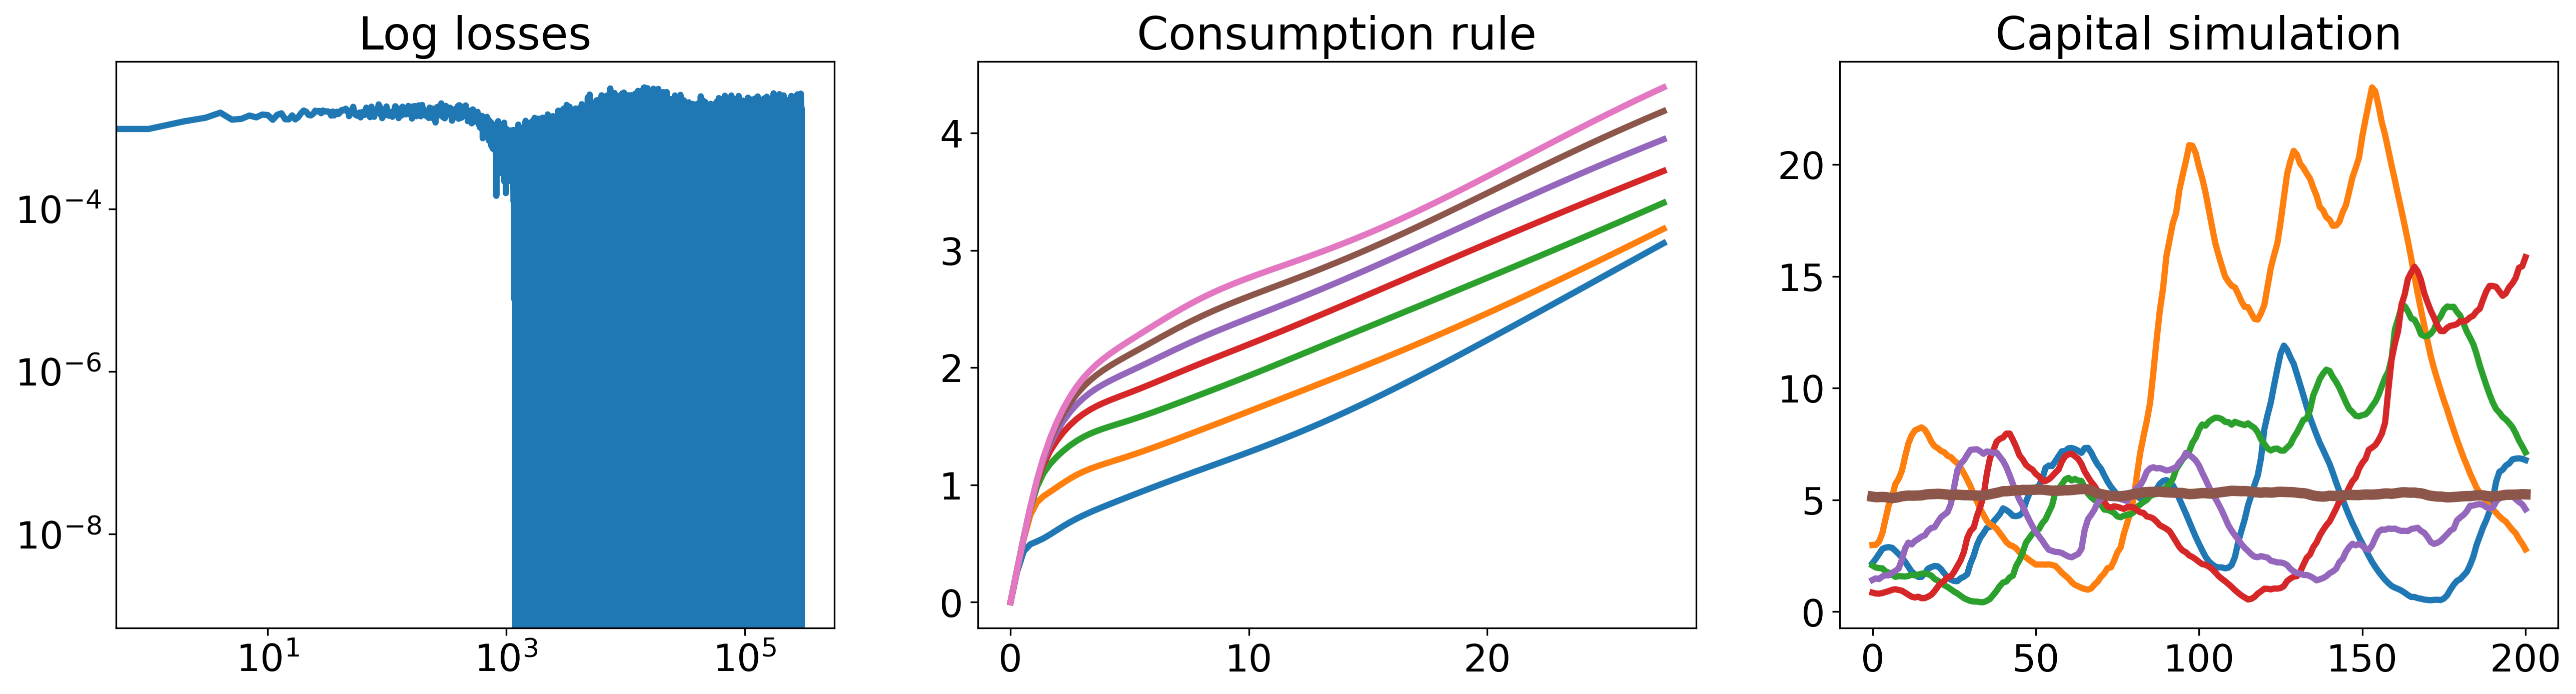

In [24]:
# Set plotting parameters for now and later
plt.rcParams['agg.path.chunksize'] = 1000
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 18

# Columns and rows in graph
rows = 1
cols = 3
    
# Width, height automatically set
height = 5*rows
width = 7*cols

fig = plt.figure()
fig.set_figwidth(width)
fig.set_figheight(height)

# Plot Learning Losses
ax = plt.subplot(rows, cols, 1)
_ = plt.plot(loss_vals)
plt.yscale('log')
plt.xscale('log')
ax.title.set_text("Log losses")

counter = 2

ax = plt.subplot(rows, cols, 2)
for i in range(decision_rule_results["c0"].shape[1]):
    plt.plot(decision_rule_results["w0"][:, i, 0], decision_rule_results["c0"][:, i, 0])
ax.title.set_text("Consumption rule")

ax = plt.subplot(rows, cols, 3)
start = 200
end = 400
drawn_agents = 5
for i in range(min(5, simulation_results["k"].shape[2])):
    plt.plot(simulation_results["k"][start:end+1, 0, i]) # DRAW ONLY BATCH N = 0
if simulation_results["k"].shape[2] != 1: # Plot mean if more than one line was drawn
    plt.plot(np.mean(simulation_results["k"][start:end+1, 0], axis=1), linewidth=5.0) # DRAW ONLY BATCH N = 0
ax.title.set_text("Capital simulation")